In [41]:
import numpy as np
import pandas as pd
import os.path
import tensorflow as tf
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import seaborn as sns


DATASET_PATH = r'../input/the-simpsons-characters-dataset'

## Exploratory Data Analysis (EDA)

Visual preview of the appearance of each character involved, aiding in understanding the diversity and nuances of character representations within the dataset. Additionally, I analyze the class distributions to gain insights into the balance or skewness among different character categories. Furthermore, I examine the distribution of image sizes across the dataset, which aids in understanding the range and variability of image dimensions.

Also explore the distribution of colors present in the images, shedding light on the predominant color schemes and variations within the dataset. These steps collectively contribute to a comprehensive understanding of the data characteristics and inform subsequent modeling decisions.

In [38]:
def proc_img(filepath):
    """
    Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    
    df = pd.concat([filepath, labels], axis=1)
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

train_dir = Path(os.path.join(DATASET_PATH, 'simpsons_dataset'))
filepaths = list(train_dir.glob(r'**/*.jpg'))

df = proc_img(filepaths)

print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

labels = df.Label.unique()

Number of pictures: 41866

Number of different labels: 42

Labels: ['chief_wiggum' 'homer_simpson' 'lisa_simpson' 'ned_flanders'
 'moe_szyslak' 'sideshow_bob' 'milhouse_van_houten' 'principal_skinner'
 'charles_montgomery_burns' 'marge_simpson' 'bart_simpson'
 'krusty_the_clown' 'abraham_grampa_simpson' 'professor_john_frink'
 'comic_book_guy' 'selma_bouvier' 'kent_brockman' 'apu_nahasapeemapetilon'
 'nelson_muntz' 'agnes_skinner' 'cletus_spuckler' 'maggie_simpson'
 'lenny_leonard' 'waylon_smithers' 'groundskeeper_willie' 'edna_krabappel'
 'barney_gumble' 'mayor_quimby' 'patty_bouvier' 'ralph_wiggum'
 'miss_hoover' 'carl_carlson' 'gil' 'rainier_wolfcastle' 'snake_jailbird'
 'martin_prince' 'sideshow_mel' 'disco_stu' 'troy_mcclure' 'fat_tony'
 'otto_mann' 'lionel_hutz']


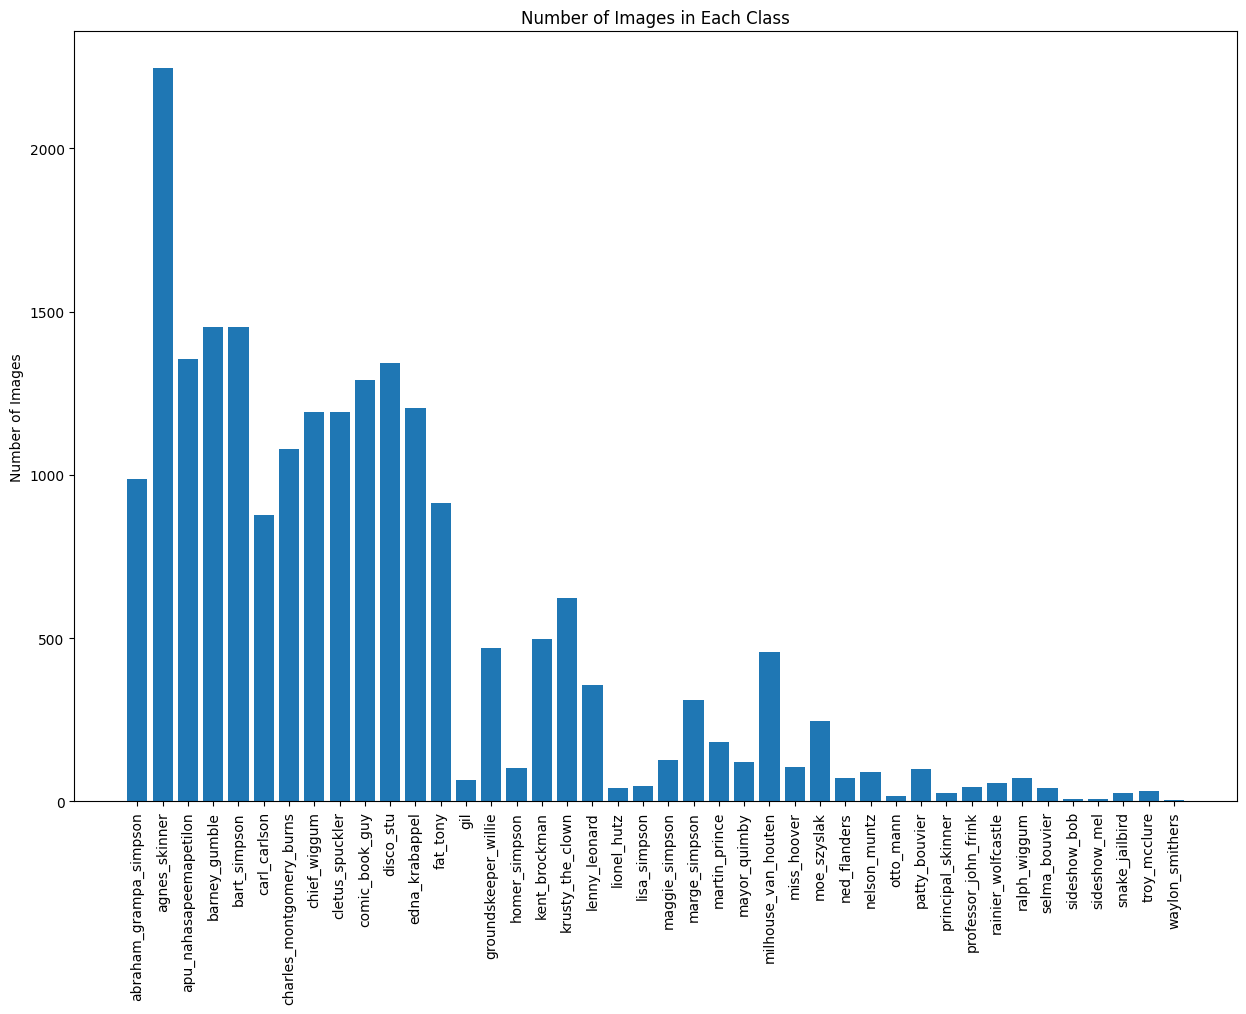

In [39]:
# Count the number of images for each class
image_counts = []
for class_name in labels:
    class_folder = os.path.join(DATASET_PATH, 'simpsons_dataset', class_name)
    image_files = [f for f in os.listdir(class_folder) if f.endswith('.jpeg') or f.endswith('.jpg')]
    image_counts.append(len(image_files))

plt.figure(figsize=(15, 10))
plt.bar(classes, image_counts)
plt.xticks(rotation=90)
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.show()

Characters: 42


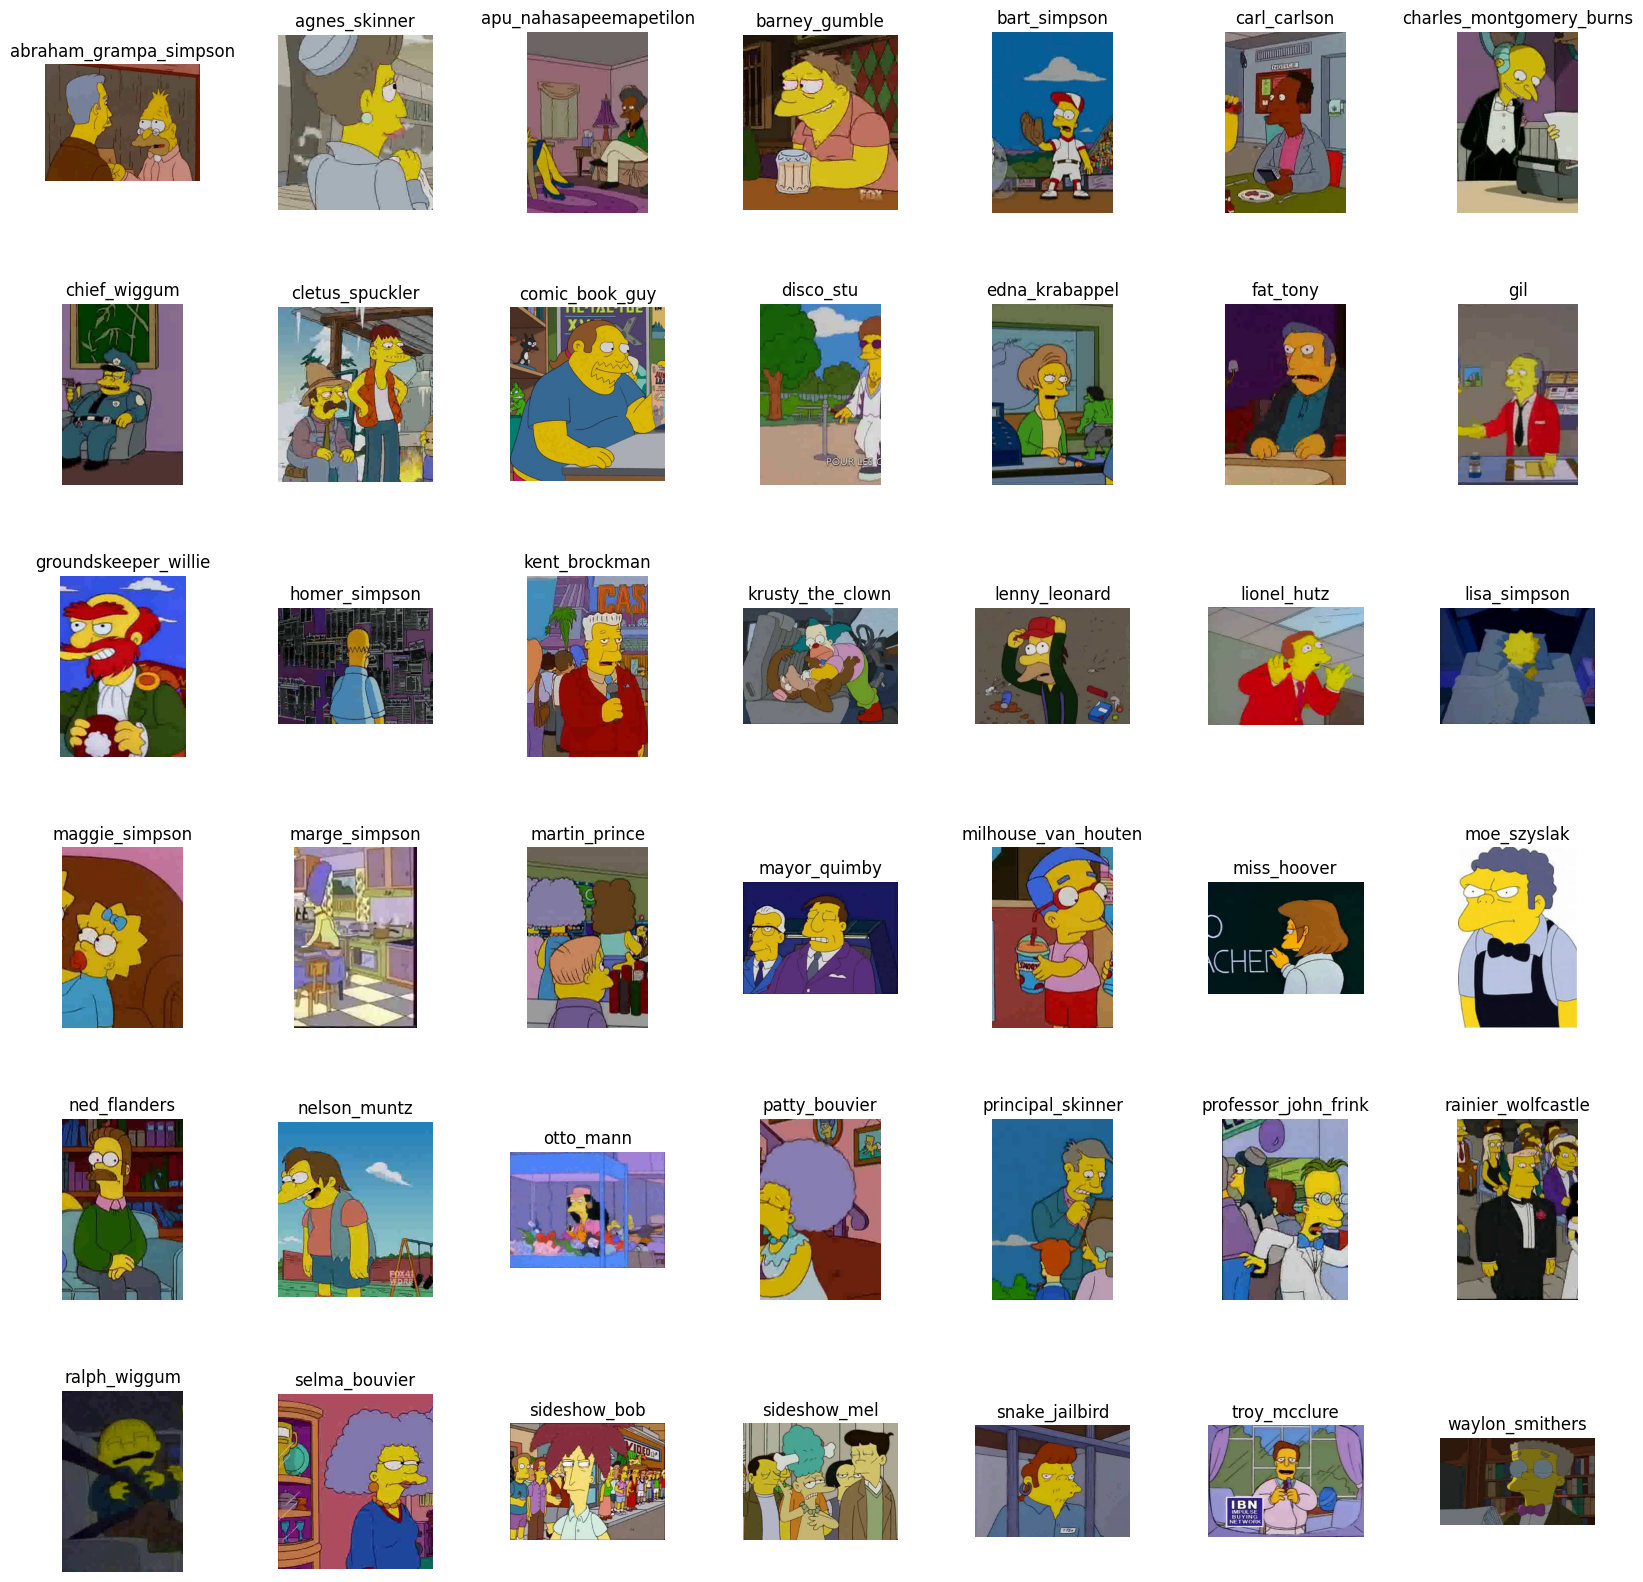

In [42]:
num_classes = len(labels)
print(f'Labels Count: {num_classes}')

rows = 6
cols = (num_classes + rows - 1) // rows

fig, axes = plt.subplots(rows, cols, figsize=(20, 20))

for i, ax in enumerate(axes.flat):
    if i < num_classes:
        sub_dir = classes[i]
        class_folder = os.path.join(CHAR_PATH, sub_dir)
        image_files = [f for f in os.listdir(class_folder) if f.endswith('.jpeg') or f.endswith('.jpg')]

        if not image_files:
            continue

        img_file = image_files[0]  # Take the first image
        img_path = os.path.join(class_folder, img_file)
        img = mpimg.imread(img_path)

        if img is None:
            continue

        ax.imshow(img)
        ax.set_title(sub_dir, ha='center', fontsize=12)
        ax.axis('off')
    else:
        ax.axis('off')

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

## Load the Images with a generator

In [3]:
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=0)

In [4]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [5]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='validation',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 26794 validated image filenames belonging to 42 classes.
Found 6698 validated image filenames belonging to 42 classes.
Found 8374 validated image filenames belonging to 42 classes.


In [6]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(42, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=20, # For final change to 50
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/838 ━━━━━━━━━━━━━━━━━━━━ 3:04:25 13s/step - accuracy: 0.0000e+00 - loss: 4.0860

I0000 00:00:1714359358.361338     121 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


838/838 ━━━━━━━━━━━━━━━━━━━━ 247s 280ms/step - accuracy: 0.4335 - loss: 2.1344 - val_accuracy: 0.6757 - val_loss: 1.1935
Epoch 2/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 83s 98ms/step - accuracy: 0.7231 - loss: 1.0029 - val_accuracy: 0.7393 - val_loss: 0.9719
Epoch 3/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 81s 96ms/step - accuracy: 0.7913 - loss: 0.7493 - val_accuracy: 0.7566 - val_loss: 0.8932
Epoch 4/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 82s 97ms/step - accuracy: 0.8296 - loss: 0.5985 - val_accuracy: 0.7846 - val_loss: 0.8001
Epoch 5/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 81s 96ms/step - accuracy: 0.8600 - loss: 0.4833 - val_accuracy: 0.8053 - val_loss: 0.7379
Epoch 6/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 83s 98ms/step - accuracy: 0.8851 - loss: 0.3863 - val_accuracy: 0.8143 - val_loss: 0.7215
Epoch 7/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 80s 95ms/step - accuracy: 0.9118 - loss: 0.3005 - val_accuracy: 0.8116 - val_loss: 0.7560
Epoch 8/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 84s 100ms/step - accuracy: 0.9262 - loss: 0.2557 - val_accu

By visualizing these metrics side by side, we can quickly identify trends and patterns in the model's performance during training. For example, if the training accuracy continues to increase while the validation accuracy stagnates or decreases, it suggests overfitting. Conversely, if both training and validation loss decrease steadily, it indicates that the model is learning effectively without overfitting.

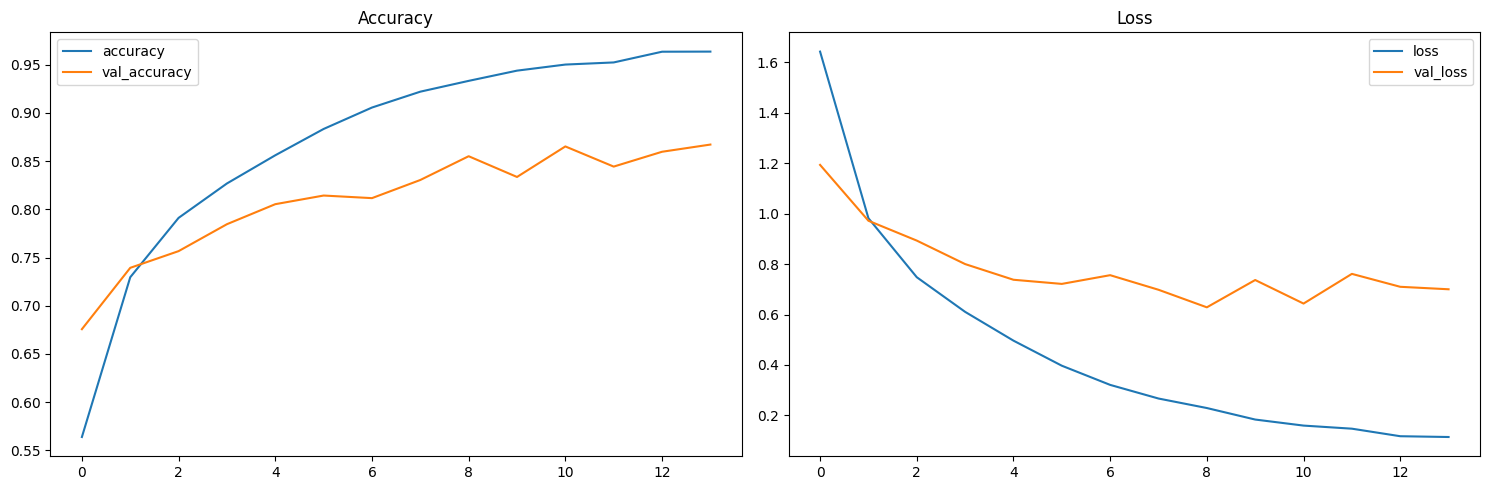

In [46]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot(ax=plt.gca())
plt.title("Accuracy")

plt.subplot(1, 2, 2)
pd.DataFrame(history.history)[['loss','val_loss']].plot(ax=plt.gca())
plt.title("Loss")

plt.tight_layout()
plt.show()

In [10]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


262/262 ━━━━━━━━━━━━━━━━━━━━ 80s 293ms/step
The first 5 predictions: ['ned_flanders', 'lisa_simpson', 'bart_simpson', 'homer_simpson', 'mayor_quimby']


In [11]:
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

Accuracy on the test set: 85.14%


In [12]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.85      0.84      0.85       388
           agnes_skinner       0.82      0.67      0.74        21
  apu_nahasapeemapetilon       0.91      0.95      0.93       225
           barney_gumble       0.96      0.55      0.70        47
            bart_simpson       0.82      0.91      0.87       531
            carl_carlson       1.00      0.69      0.82        42
charles_montgomery_burns       0.87      0.86      0.86       480
            chief_wiggum       0.94      0.87      0.91       379
         cletus_spuckler       0.71      0.62      0.67        16
          comic_book_guy       0.90      0.88      0.89       184
               disco_stu       1.00      0.50      0.67         2
          edna_krabappel       0.85      0.90      0.88       196
                fat_tony       0.82      0.75      0.78        12
                     gil       0.86      0.86      0.86         7
    groun

Generates a heatmap of the normalized confusion matrix, providing insights into the performance of our classification model on the test dataset.

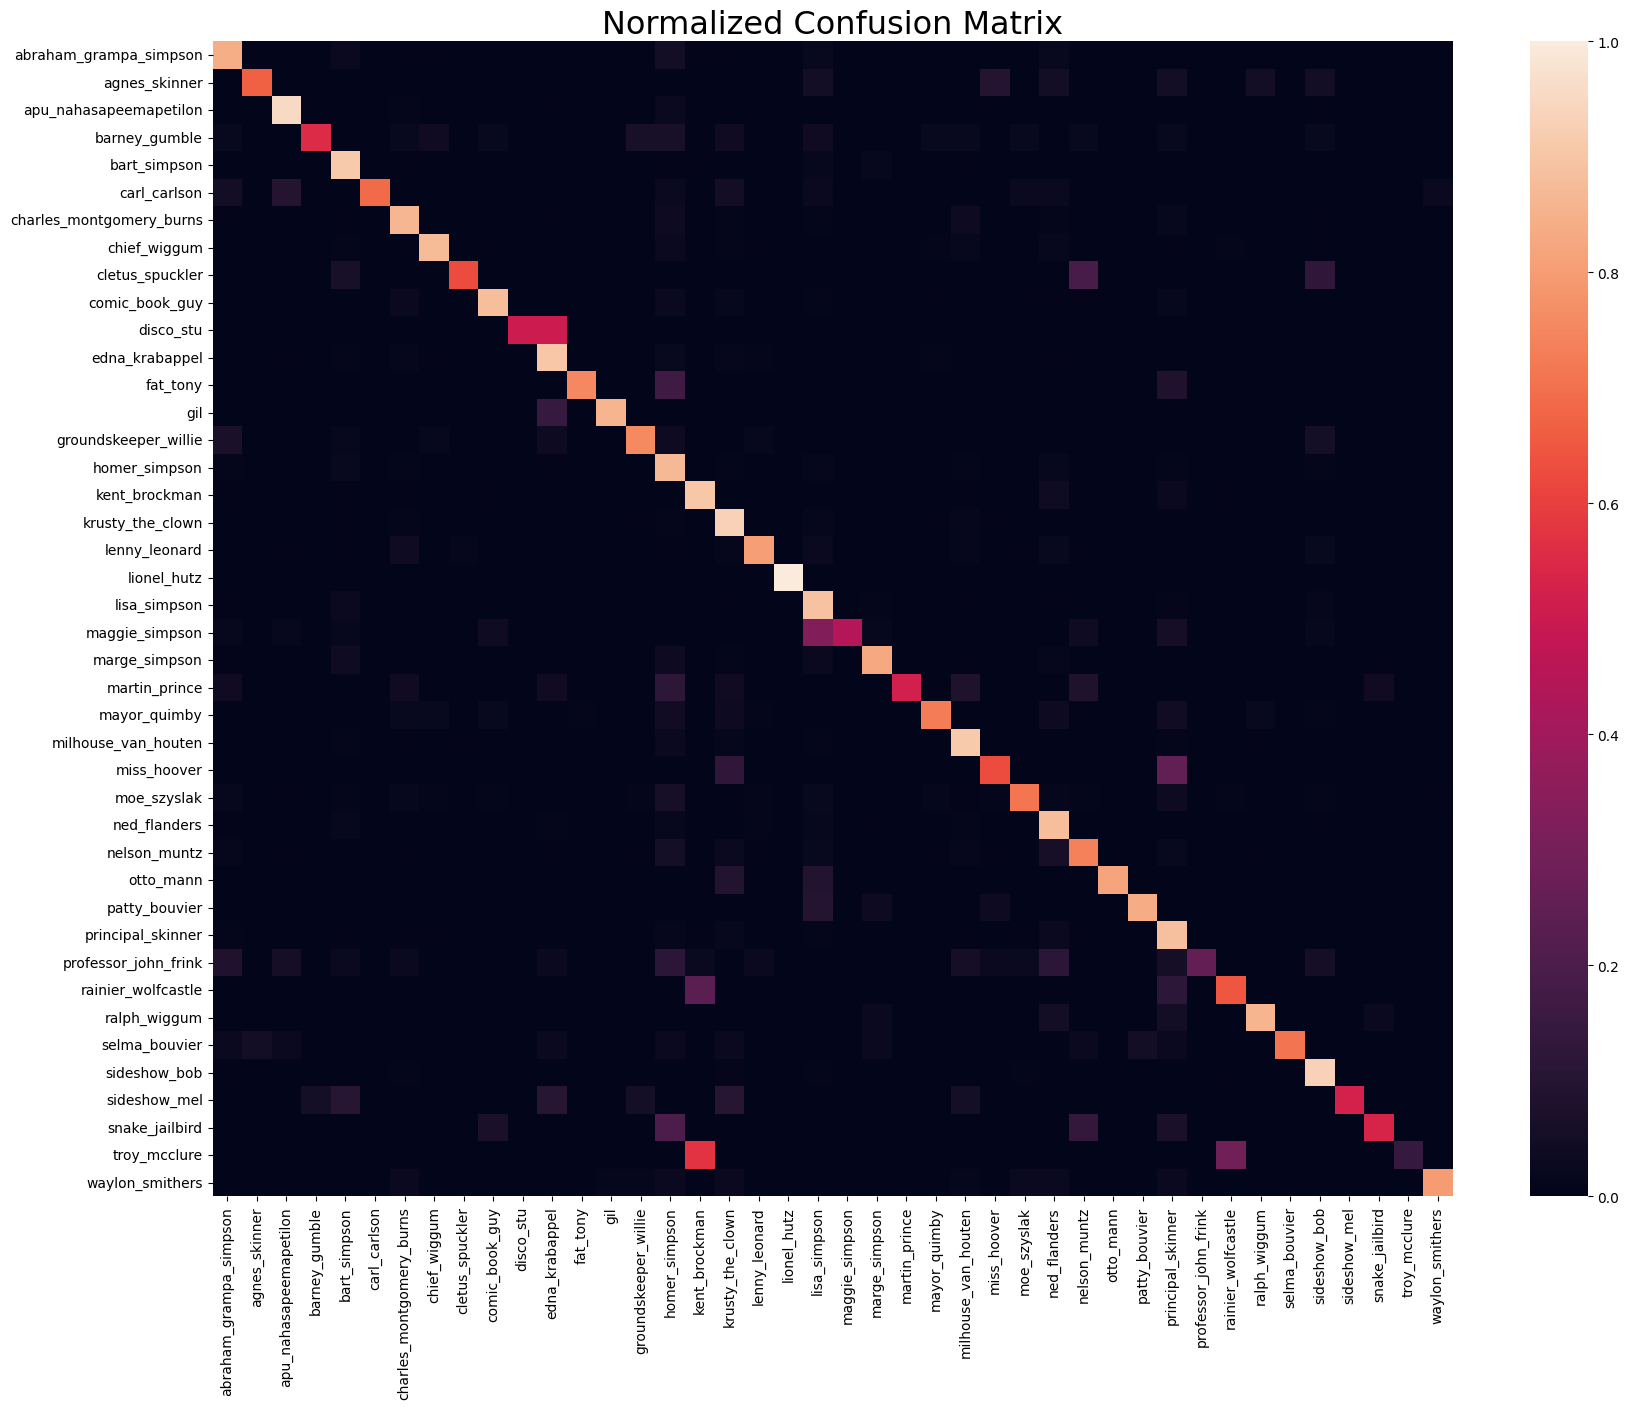

In [13]:
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (20,15))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.show()

## Prediction Interpretation

Based on the evaluation results, we interpret the model's performance and draw conclusions regarding its effectiveness in recognition of character.

Success Percentage 66.67


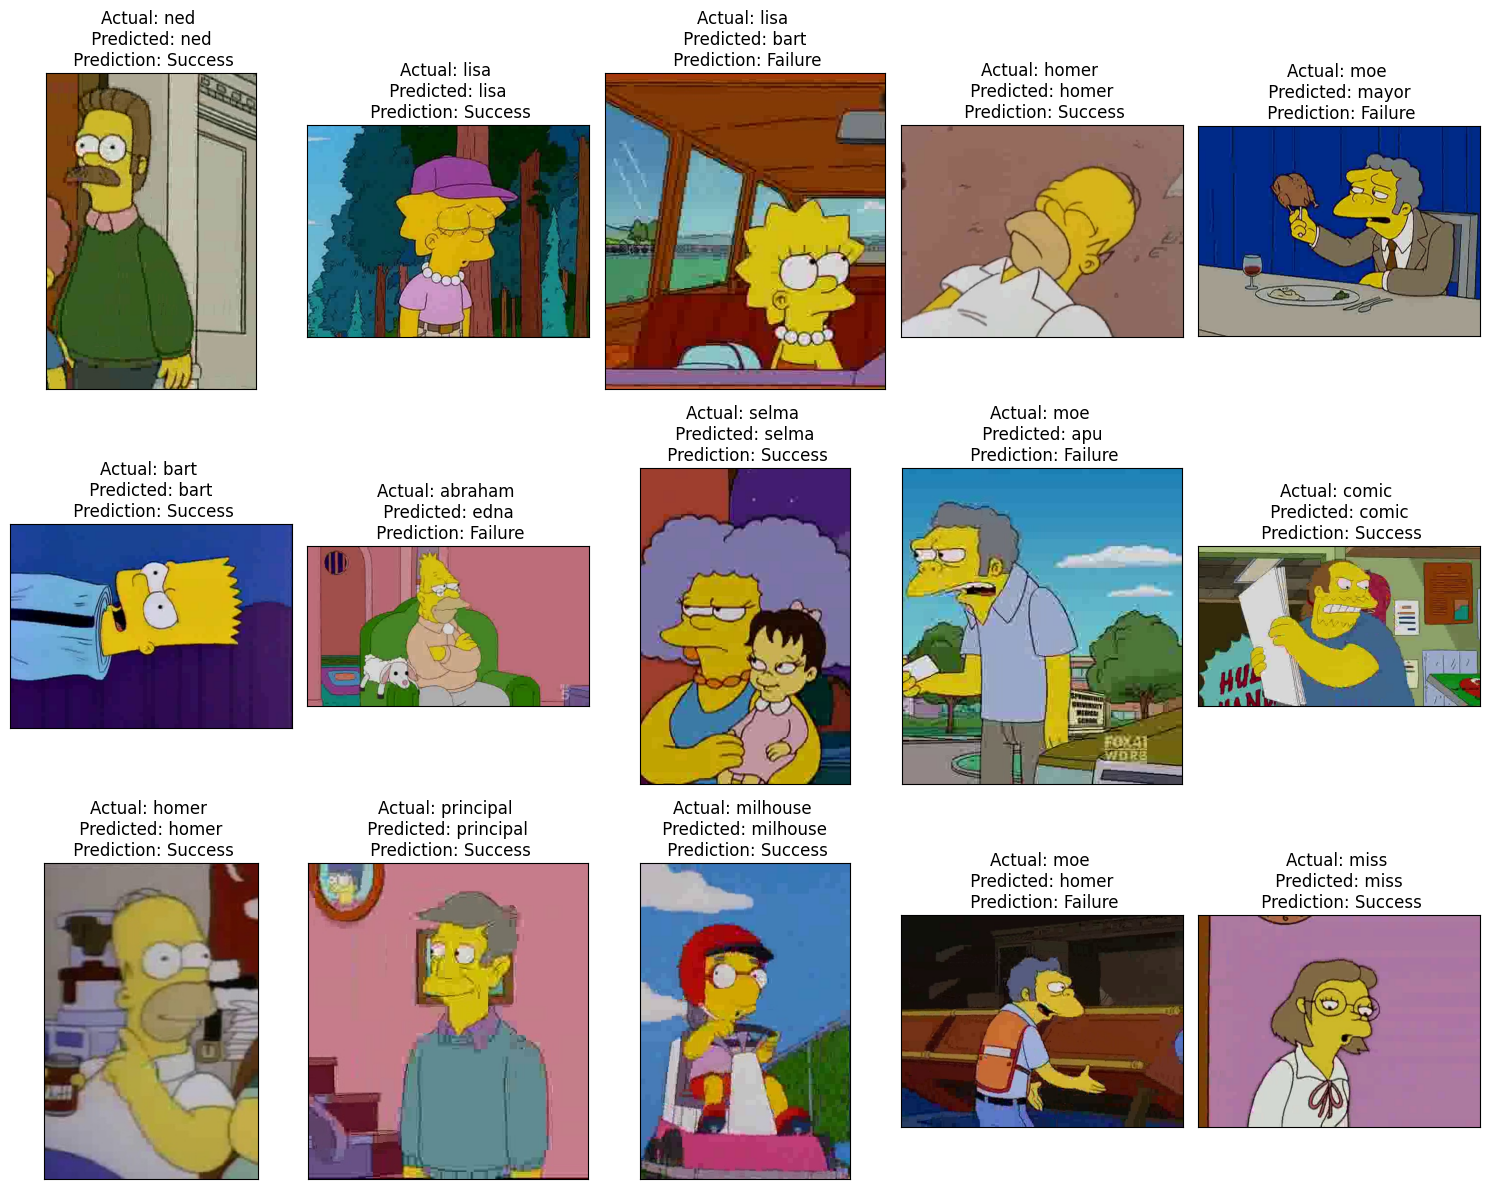

In [23]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 12), subplot_kw={'xticks': [], 'yticks': []})

success_count = 0
failure_count = 0

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    
    true_label = test_df.Label.iloc[i].split('_')[0]
    predicted_label = pred[i].split('_')[0]
    
    result = 'Success' if (true_label==predicted_label) else 'Failure'
    if result == 'Success':
        success_count += 1
    else:
        failure_count += 1
        
    ax.set_title(f"Actual: {true_label} \n Predicted: {predicted_label} \n Prediction: {result}")

print(f"Success Percentage {round((success_count*100)/(success_count+failure_count), 2)}")
    
plt.tight_layout()
plt.show()